In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

### Задание

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

### Данные

```ab_users_data``` – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи  
```ab_orders``` – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ  
```ab_products``` – подробная информация о продуктах, их название и стоимость  

### Выбор метрик

Целевые метрики: 
- Общая сумма заказов 
- Доля отменённых заказов


In [2]:
ab_users_data = pd.read_csv('ab_users_data.csv')
ab_orders = pd.read_csv('ab_orders.csv')
ab_products = pd.read_csv('ab_products.csv')

### ab_users_data.csv

In [3]:
ab_users_data.shape

(4337, 6)

In [4]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


### ab_orders.csv

In [5]:
ab_orders.shape

(4123, 3)

In [6]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


### ab_products.csv

In [7]:
ab_products.shape

(87, 3)

In [8]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


### Соединяем таблички

In [9]:
merged = pd.merge(ab_users_data, ab_orders, on='order_id', how='left')

In [10]:
merged['product_ids_arr'] = merged.product_ids.apply(lambda x: list(ast.literal_eval(x)))

In [11]:
merged.head(2)

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_ids_arr
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}","[75, 84, 53, 22]"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}","[56, 76, 39]"


In [12]:
exploded_products = merged.explode('product_ids_arr')
exploded_products.head(5)

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_ids_arr
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",75
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",84
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",53
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",22
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",56


In [13]:
merged_with_prices = pd.merge(exploded_products, ab_products, 
                              left_on='product_ids_arr', right_on='product_id', how='left')

In [14]:
merged_with_prices.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_ids_arr,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",75,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",84,84,мандарины,90.4
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",53,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",22,22,сок мультифрукт,120.0
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",56,56,сосиски,150.0


### Подсчёт отменённых заказов в каждой группе и общего числа заказов в каждой группе

In [15]:
cancelled_group0 = merged_with_prices.query('group == 0 & action == "cancel_order"').shape[0]
cancelled_group1 = merged_with_prices.query('group == 1 & action == "cancel_order"').shape[0]

total_orders_group0 = merged_with_prices[merged_with_prices['group'] == 0].shape[0]
total_orders_group1 = merged_with_prices[merged_with_prices['group'] == 1].shape[0]

### Тест на различие пропорций (z-test)

**Нулевая гипотеза (H0)**: Пропорции равны в обеих группах (нет статистически значимого различия).  
**Альтернативная гипотеза (H1)**: Пропорции отличаются в двух группах (есть статистически значимое различие).

In [16]:
z_stat, p_value = proportions_ztest([cancelled_group0, cancelled_group1], 
                                     [total_orders_group0, total_orders_group1])
p_value < 0.05

False

Нет статистически важных различий между долями отмен заказов в каждой группе. Исходя из результатов этого теста, **не стоит выкатывать новые изменения**

### Подсчёт суммы заказа

In [17]:
merged_with_prices.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,product_ids_arr,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",75,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",84,84,мандарины,90.4
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",53,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",22,22,сок мультифрукт,120.0
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",56,56,сосиски,150.0


In [18]:
total_order_cost = merged_with_prices \
                    .groupby(['group', 'order_id', 'action'], as_index=False) \
                    .agg({'price':'sum'}).rename(columns={'price':'total_order_cost'})

In [19]:
total_order_cost.head()

,group,order_id,action,total_order_cost
0,0,1255,create_order,408.7
1,0,1257,create_order,310.2
2,0,1258,cancel_order,85.0
3,0,1258,create_order,85.0
4,0,1261,create_order,430.7


### Тест Шапиро-Уилка

Нарежу получившийся датасет на группы, чтобы проверить распределение (через тест Шапиро-Уилка). Также визуализирую группы, чтобы визуально оценить нормальность

**H0 Шапиро-Уилка**: данные подчиняются нормальному распределению  
**H1 Шапиро-Уилка**: данные не подчиняются нормальному распределению

Если ```p_value``` окажется меньше 0.05, я смогу отклонить нулевую гипотезу и заключить, что данные **не** подчиняются нормальному распределению

In [20]:
group0 = total_order_cost.query('group == 0 & action == "create_order"').total_order_cost

In [21]:
group1 = total_order_cost.query('group == 1 & action == "create_order"').total_order_cost

In [22]:
statistic, p_value = shapiro(group0)
p_value < 0.05

True

In [23]:
statistic, p_value = shapiro(group1)
p_value < 0.05

True

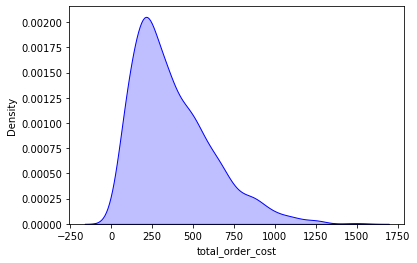

In [24]:
sns.kdeplot(group0, shade=True, color='blue', label='Control Group')

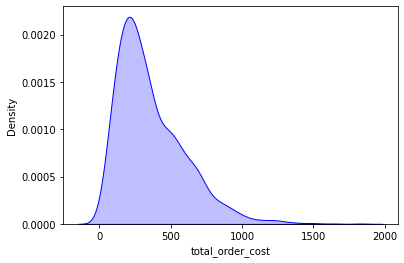

In [25]:
sns.kdeplot(group1, shade=True, color='blue', label='Experimental Group')

Визуально данные не подчиняются нормальному распределению. 

Согласно тесту Шапиро-Уитни ```p_value``` для обеих групп меньше 0.05, то есть я могу отклонить нулевую гипотезу и заключить, что **данные распределены ненормально**

### Тест Манна-Уитни

Так как распределение ненормально, я могу воспользоваться тестом Манна-Уитни. Он рассматривает медианные (а не средние) значения, что важно для случая, когда данные распределены ненормально

**H0 Манна-Уитни**: распределения в двух выборках идентичны (нет статистически значимых различий)  
**H1 Манна-Уитни**: распределения в двух выборках различны (есть статистически значимые различия) 

Если я получу ```p_value``` меньше 0.05, я смогу отклонить нулевую гипотезу и заключить, что есть статистически значимые различия между выборками. Если ```p_value``` окажется больше 0.05, у меня не будет оснований отклонить нулевую гипотезу, это будет означать, что между выборками нет статистически значимых различий

In [26]:
statistic, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
print(p_value)
print(p_value < 0.05)

0.06694863033214293
False


На основе проведёноого теста Манна-Уитни нет статистически важных различий между двумя группами. **Нет оснований выкатывать изменение на всех, несмотря на то, что в экспериментальной группе сумма заказов больше** (группировка ниже)

In [27]:
total_order_cost.groupby(['group', 'action'], as_index=False).agg({'total_order_cost':'sum'})

,group,action,total_order_cost
0,0,cancel_order,29762.1
1,0,create_order,602491.7
2,1,cancel_order,48939.7
3,1,create_order,910009.3
